In [178]:
import torch
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from fancyimpute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.path import Path

In [254]:
BENCHMARKS = ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'GSM8K', 'XWinograd', 'HumanEval']
MODEL_FAMILIES = {'pythia': 'Pythia',
                  'Llama-2': 'Llama-2',
                  'llama-': 'Llama',
                  'Qwen1.5': 'Qwen-1.5',
                  'Qwen-': 'Qwen',
                  'falcon': 'Falcon',
                  'bloom': 'BLOOM',
                  'gpt-neox': 'GPT-Neo/J',
                  'opt': 'OPT',
                  'xglm': 'XGLM',
                  'CodeLlama': 'CodeLlama',
                  'starcoder': 'StarCoder'
}


def load_leaderboard_data(family_name: str = None):
    leaderboard = pd.read_csv('leaderboards/base_llm_benchmark_eval.csv')
    if family_name is not None:
        leaderboard = leaderboard[leaderboard['Model'].str.contains(family_name)]
    return leaderboard


def apply_pca(leaderboard: pd.DataFrame,
              benchmarks: list = BENCHMARKS,
              n_components: int = 5,
              standardize: bool = True
):
    
    leaderboard_for_pca = leaderboard[benchmarks]

    if standardize:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(leaderboard_for_pca)
    else:
        scaled_data = leaderboard_for_pca


    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)
    principal_df = pd.DataFrame(
        data=principal_components, 
        columns=[f'PC-{i}' for i in range(1, n_components+1)],
        index = leaderboard_for_pca.index
    )
    explained_variance = pca.explained_variance_ratio_
    pca_components = pd.DataFrame(
        pca.components_,
        columns=leaderboard_for_pca.columns,
        index=[f'PC-{i}' for i in range(1, n_components+1)]
    )

    return principal_df, explained_variance, pca_components





def pca_imputation(leaderboard, 
                        benchmarks=BENCHMARKS, 
                        test_df=None, 
                        n_components=1, 
                        max_iter=1000, 
                        tol=1e-4, 
                        boundary=[0.0, 1.0], 
                        verbose=True):
    """
    Impute missing values in both training and test DataFrames using PCA, 
    with PCA being fitted on the training data only and both DataFrames being refined iteratively until convergence.

    Args:
        train_df: A pandas DataFrame with potential missing values, used to fit PCA.
        test_df: A pandas DataFrame with potential missing values, used to impute missing values using the fitted PCA.
        n_components: Number of principal components to keep.
        max_iter: Maximum number of iterations for convergence.
        tol: Tolerance for stopping criteria.
        boundary: the boundary for the imputed values, if None, no boundary is applied.
    """

    train_df = leaderboard[benchmarks]

    if boundary is not None:
        assert (isinstance(boundary, list) or isinstance(boundary, tuple)) and len(boundary) == 2
    
    # Standardize training data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df)

    # Print ratio of missing values in training data
    if verbose:
        print(f"Missing values in training data: {np.sum(np.isnan(train_scaled)) / train_scaled.size:.2%}")
    
    # Initial imputation for training data
    imputer = SimpleImputer(strategy="mean")
    train_imputed = imputer.fit_transform(train_scaled)
    
    # Iterate to refine imputation on training data
    for _ in range(max_iter):
        pca = PCA(n_components=n_components)
        train_pca = pca.fit_transform(train_imputed)
        train_inverse = pca.inverse_transform(train_pca)

        if np.allclose(train_imputed, train_inverse, atol=tol):
            break

        train_imputed[train_df.isna().values] = train_inverse[train_df.isna().values]

    # Inverse the scaling for training data
    train_final = scaler.inverse_transform(train_imputed)
    if boundary is not None:
        train_final = train_final.clip(boundary[0], boundary[1])

    train_final_df = pd.DataFrame(train_final, columns=leaderboard[benchmarks].columns, index=leaderboard[benchmarks].index)

    # Apply the fitted transformations to the test data
    if test_df is not None:
        # Prepare test data using the same scaler and imputer as the training data
        test_scaled = scaler.transform(test_df)

        if verbose:
            # Print ratio of missing values in test data
            print(f"Missing values in test data: {np.sum(np.isnan(test_scaled)) / test_scaled.size:.2%}")

        # Initial imputation for test data
        test_imputed = imputer.transform(test_scaled)

        # Iterate to refine imputation on test data
        for _ in range(max_iter):
            test_pca = pca.transform(test_imputed)
            test_inverse = pca.inverse_transform(test_pca)

            if np.allclose(test_imputed, test_inverse, atol=tol):
                break

            test_imputed[test_df.isna().values] = test_inverse[test_df.isna().values]

        # Inverse the scaling for test data
        test_final = scaler.inverse_transform(test_imputed)
        if boundary is not None:
            test_final = test_final.clip(boundary[0], boundary[1])
        test_final_df = pd.DataFrame(test_final, columns=test_df.columns, index=test_df.index)
    else:
        test_final_df = None
    
    return train_final_df, test_final_df


def plot_pca_explained_variance(explained_variance: list):
    """ Plots the explained variance of each principal component.
    Corresponds to Figure 2(a).
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.bar(range(1, len(explained_variance)+1), explained_variance)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Explained Variance of Principal Components')

    top_3_variance_sum = sum(explained_variance[:3])
    print(f'Top 3 components explain {top_3_variance_sum:.3f} of the variance')

    brace_height = explained_variance[0] + 0.05
    brace_x_start = 1 - 0.4
    brace_x_end = 3 + 0.4

    vertices = [
        (brace_x_start, brace_height),  # Left bottom of the brace
        (brace_x_start, brace_height + 0.01),  # Left top of the brace
        (brace_x_end, brace_height + 0.01),  # Right top of the brace
        (brace_x_end, brace_height),  # Right bottom of the brace
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO]

    path = Path(vertices, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1.5, edgecolor='gray')
    ax.add_patch(patch)
    ax.annotate(f"{top_3_variance_sum:.3f}", 
                ((brace_x_start + brace_x_end) / 2, brace_height+0.02),
                textcoords="data",
                ha="center", va="bottom", fontsize=11)
    ax.set_ylim([0.0, 1.0])
   
    return


def plot_pca_weights(pca_components: pd.DataFrame):
    plt.figure(figsize=(6, 3))
    sns.heatmap(pca_components, annot=True, fmt='.2f', cmap='coolwarm', cbar=False)
    plt.title('Principal Component Weights')
    plt.xticks(rotation=30)

    return 




Missing values in training data: 7.59%
Top 3 components explain 0.967 of the variance


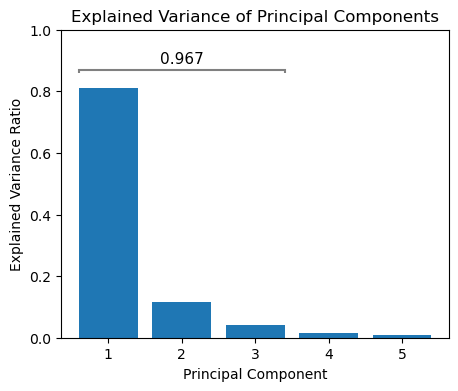

In [179]:
leaderboard = load_leaderboard_data()
imputed_metric_df, _ = pca_imputation(leaderboard)
principal_df, explained_variance, pca_components = apply_pca(imputed_metric_df, n_components=5, standardize=False)
leaderboard = pd.concat([leaderboard, principal_df], axis=1)
plot_pca_explained_variance(explained_variance)

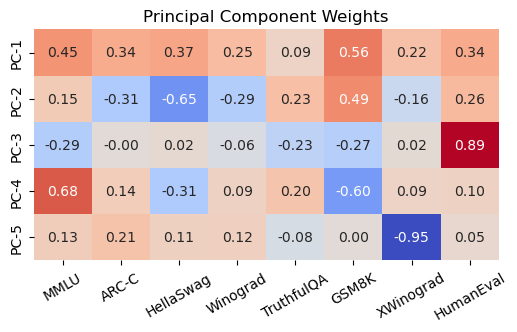

In [180]:
plot_pca_weights(pca_components)

In [256]:
def correlation_pc_log_compute_one_family(leaderboard: pd.DataFrame,
                                          pca_components: pd.DataFrame,
                                          family_name: str,
                                          metric: str = 'mse',
                                          pc_number: int = 1,
):
    """ Computes the correlation between a principal component and the log of compute for a given family of models.
    In the original paper they use statsmodels.OLS, but we use sklearn.LinearRegression here.
    """ 
    
    leaderboard = leaderboard[leaderboard['Model'].str.contains(family_name)]
    compute = leaderboard['FLOPs (1E21)']
    log_compute = np.log10(compute).to_numpy().reshape(-1, 1)

    pc_weights = pca_components.loc[f'PC-{pc_number}']
    pc_values = leaderboard[f'PC-{pc_number}'].to_numpy()

    model = LinearRegression()
    model.fit(log_compute, pc_values)

    y_pred = model.predict(log_compute)

    if metric == 'mse':
        err = mean_squared_error(pc_values, y_pred)
    else:
        raise ValueError(f"Invalid metric: {metric}")
    r2 = r2_score(pc_values, y_pred)
    
    return pc_values, model.coef_[0], model.intercept_, r2


def plot_correlation_pc_log_compute_one_family(leaderboard: pd.DataFrame,
                                               family_name: str,
                                               r2: float,
                                               coefficient: float,
                                               intercept: float,
                                               pc_number: int = 1
):
    leaderboard = leaderboard[leaderboard['Model'].str.contains(family_name)]
    leaderboard['log_compute'] = np.log10(leaderboard['FLOPs (1E21)'])

    sns.regplot(x='log_compute', y='PC-1', data=leaderboard, ci=95)
    plt.xlabel('Log$_{10}$(FLOPs (1E21))')
    plt.ylabel(f'PC-{pc_number}')
    plt.title(MODEL_FAMILIES[family_name])

    plt.text(-0.9, -0.17, f'$R^2 = {r2:.2f}$', fontsize=12)
    plt.text(-0.9, -0.2, f'$y = {coefficient:.2f}x + {intercept:.2f}$', fontsize=12)

    return


def plot_correlation_pc_log_compute_all_families(leaderboard: pd.DataFrame,
                                                 pc_number: int = 1
):
    

    data = {
        'model': MODEL_FAMILIES.keys(),
        'log_compute': [],
        'pc_values': [],
        'r2': [],
        'coefficient': [],
        'intercept': []
    }

    for family_name in data['model']:
        print(f'Processing {family_name}')
        pc_values, coefficient, intercept, r2 = correlation_pc_log_compute_one_family(leaderboard, 
                                                                                      pca_components, 
                                                                                      family_name, 
                                                                                      pc_number=pc_number)
        data['pc_values'].append(pc_values)
        data['r2'].append(r2)
        data['coefficient'].append(coefficient)
        data['intercept'].append(intercept)
        data['log_compute'].append(np.log10(leaderboard[leaderboard['Model'].str.contains(family_name)]['FLOPs (1E21)']))

    df = pd.DataFrame(data)
    def plot_facet(data, **kwargs):

        model = data['model'].iloc[0]
        slope = data['coefficient'].iloc[0]
        intercept = data['intercept'].iloc[0]
        r2 = data['r2'].iloc[0]
        
        sns.regplot(x='log_compute', y='pc_values', data=data, ci=95, scatter_kws={'s': 20}, line_kws={'lw': 2})
        plt.xlabel('Log$_{10}$(FLOPs (1E21))')
        plt.ylabel('PC-1')
        plt.title(model)
        plt.text(0.05, 0.8, f'$R^2$ = {r2}\ny = {slope}x {intercept:+}', fontsize=7, transform=plt.gca().transAxes)

    g = sns.FacetGrid(df, col='model', col_wrap=6, height=2, aspect=1)
    g.map_dataframe(plot_facet)
    g.tight_layout()
    return


In [233]:
pc_values, coefficient, intercept, r2 = correlation_pc_log_compute_one_family(leaderboard=leaderboard,
                                      pca_components=pca_components,
                                      family_name='pythia')

/tmp/ipykernel_3648416/2337087617.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leaderboard['log_compute'] = np.log10(leaderboard['FLOPs (1E21)'])


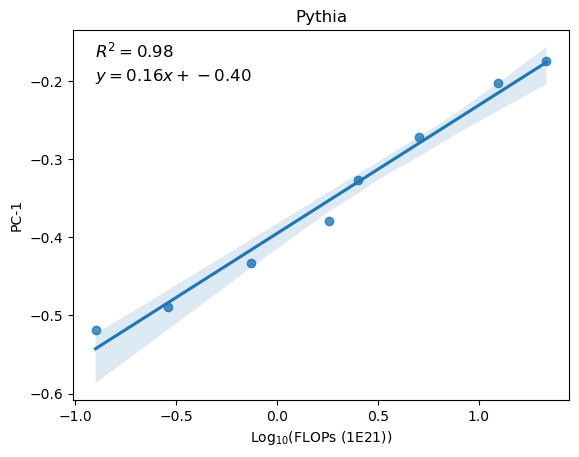

In [241]:
plot_correlation_pc_log_compute_one_family(leaderboard=leaderboard,
                                            family_name='pythia',
                                            r2=r2,
                                            coefficient=coefficient,
                                            intercept=intercept)

Processing pythia
Processing Llama-2
Processing llama-
Processing Qwen1.5
Processing Qwen-
Processing falcon
Processing bloom
Processing gpt-neox
Processing opt
Processing xglm
Processing CodeLlama
Processing starcoder


/home/jsalle/.conda/envs/p11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


ValueError: setting an array element with a sequence.

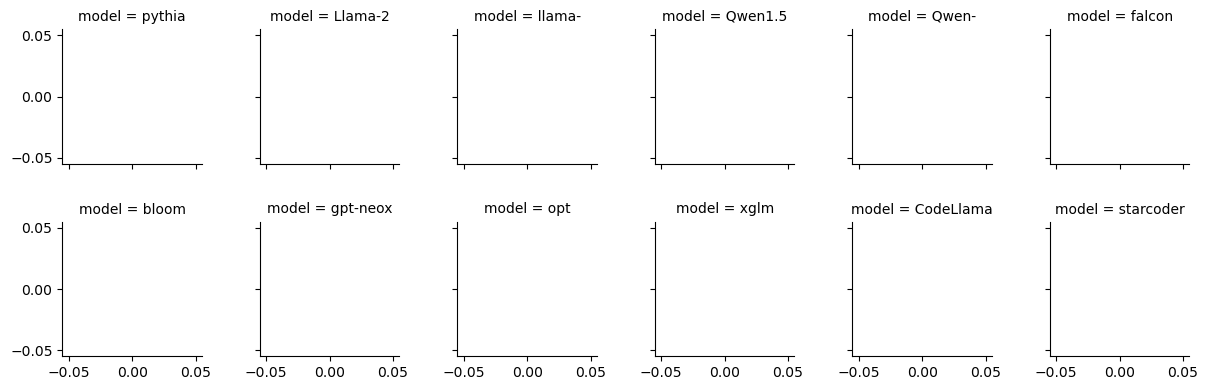

In [257]:
plot_correlation_pc_log_compute_all_families(leaderboard=leaderboard)